In [1]:
import matplotlib.pyplot as plt
import os 
from PIL import Image
import pandas as pd
from torchvision import transforms, models
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
from benchmark_eval.models import decoders
from benchmark_eval.models.base import resnet 
from benchmark_eval.geonet_src import metrics





%matplotlib inline

/home/sl636/miniconda3/envs/swav-1/lib/python3.6/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


**1.** Download the data from https://drive.google.com/drive/folders/1GDL1pvlDCcsyEwafe7N41WtS7doFlju3, and unzip the folder. You should have three folders: imgs with the satellite images, masks and masks_filled with the respective masks, either as delineated boundaries, or filled segmentation masks.

**2.** Using subplots, plot 5 example images and their respective masks

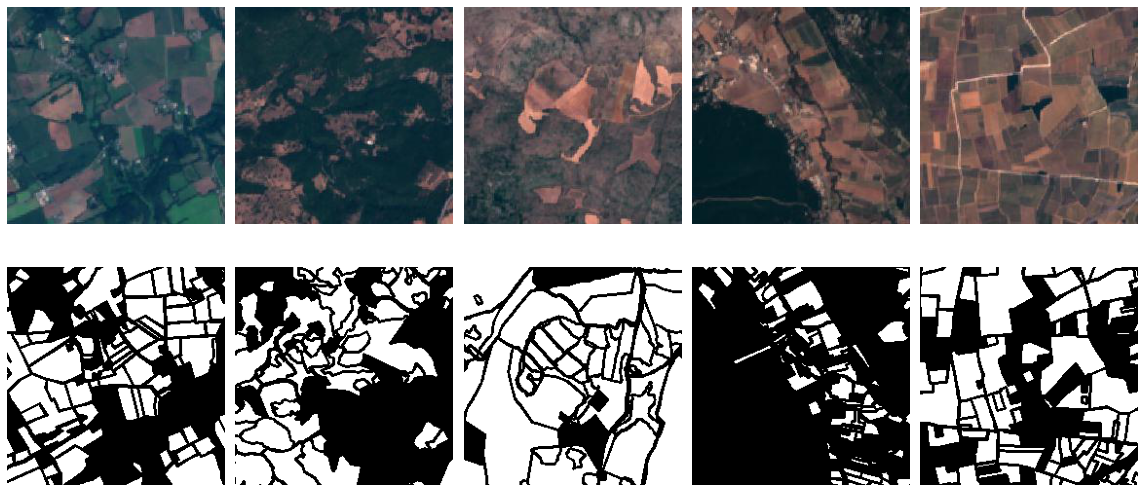

In [2]:
imgs_path = "crop_delineation/imgs"
imgs = sorted(os.listdir(imgs_path))
masks_path = "crop_delineation/masks_filled"
masks = sorted(os.listdir(masks_path))

rows, cols = 2, 5

fig, axs = plt.subplots(rows, cols, figsize=(16, 8))
for row in range(rows):
    for col in range(cols):
        if row == 0:
            img = Image.open(os.path.join(imgs_path, imgs[col]))
            axs[row, col].imshow(img)
            axs[row, col].axis('off')
        else:
            mask = Image.open(os.path.join(masks_path, masks[col]))
            axs[row, col].imshow(mask, cmap='gray')
            axs[row, col].axis('off')
plt.tight_layout()
plt.show()
        

**3.** Make a dataloader to prepare data for training

In [10]:
# Create custom DataLoader class

class CropDelineationDataset(Dataset):
    def __init__(self, csv_file, img_dir, mask_dir, split, transform=None, img_transform=None, mask_transform=None):
        self.data_frame = pd.read_csv(csv_file)
        self.data_frame = self.data_frame[self.data_frame['split'] == split]
        self.img_dir = img_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.img_transform = img_transform
        self.mask_transform = mask_transform

    def __len__(self):
        return len(self.data_frame)

    def __getitem__(self, idx):
        img_name = os.path.join(self.img_dir, str(self.data_frame.iloc[idx, 1]) + '.jpeg') 
        mask_name = os.path.join(self.mask_dir, str(self.data_frame.iloc[idx, 1]) + '.png')  

        image = Image.open(img_name).convert('RGB')
        mask = Image.open(mask_name).convert('L')  
        
        if self.img_transform:
            image = self.img_transform(image)
            mask = self.mask_transform(mask)

        return image, mask.type(torch.LongTensor)

mean = [0.2384, 0.2967, 0.3172]
std = [0.1873, 0.1226, 0.1138]

img_transform = transforms.Compose([
    # Add more here if needed, this dataset is already cropped and sized for us
    transforms.ToTensor(),
    transforms.Normalize(mean, std)

])

mask_transform = transforms.Compose([
    # Add more here if needed, this dataset is already cropped and sized for us
    transforms.ToTensor()
])

# Instantiate dataloaders for train and test splits
train_dataset = CropDelineationDataset(csv_file='crop_delineation/clean_data.csv',
                              img_dir='crop_delineation/imgs',
                              mask_dir='crop_delineation/masks_filled',
                              split='train',
                              transform=True,
                              img_transform=img_transform,
                              mask_transform=mask_transform)

val_dataset = CropDelineationDataset(csv_file='crop_delineation/clean_data.csv',
                              img_dir='crop_delineation/imgs',
                              mask_dir='crop_delineation/masks_filled',
                              split='val',
                              transform=True,
                              img_transform=img_transform,
                              mask_transform=mask_transform)

test_dataset = CropDelineationDataset(csv_file='crop_delineation/clean_data.csv',
                             img_dir='crop_delineation/imgs',
                             mask_dir='crop_delineation/masks_filled',
                             split='test',
                             transform=True,
                             img_transform=img_transform,
                             mask_transform=mask_transform)


batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

Show examples from the dataloader to make sure it works

In [4]:
def plot_examples(data_loader, num_examples=3):
    fig, axs = plt.subplots(2, num_examples, figsize=(num_examples*2, 4))
    for i, (image, mask) in enumerate(data_loader):
        if i >= num_examples:
            break
        # image, mask now contains batch_size images and masks, we only plot the first element of the batch
        axs[0, i].imshow(image[0].permute(1, 2, 0))
        axs[0, i].axis('off')
        
        axs[1, i].imshow(mask[0].squeeze(), cmap='gray')
        axs[1, i].axis('off')
    
    plt.tight_layout()
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


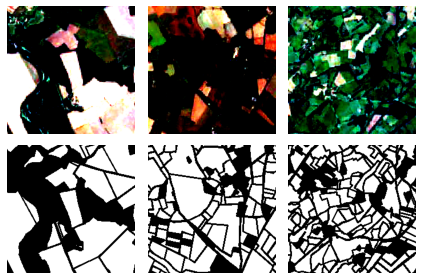

In [5]:
plot_examples(train_loader)

Looks weird right? That's because we've normalized the data, we need to "undo" the normalization if we want to visualize the images correctly. However, we want to feed the model normalized images because it speeds up convergence

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


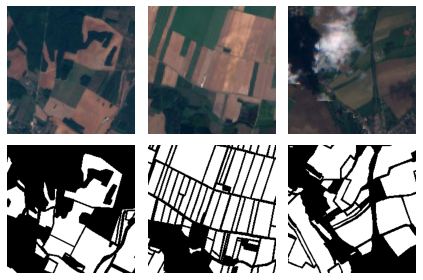

In [6]:
def plot_examples(data_loader, inv_trans, num_examples=3):
    fig, axs = plt.subplots(2, num_examples, figsize=(num_examples*2, 4))
    for i, (image, mask) in enumerate(data_loader):
        if i >= num_examples:
            break
        # image, mask now contains batch_size images and masks, we only plot the first element of the batch
        axs[0, i].imshow(inv_trans(image[0]).permute(1, 2, 0))
        axs[0, i].axis('off')
        
        axs[1, i].imshow(mask[0].squeeze(), cmap='gray')
        axs[1, i].axis('off')
    
    plt.tight_layout()
    plt.show()

invTrans = transforms.Compose([transforms.Normalize(mean = [-mean[i]/std[i] for i in range(3)],
                                                    std = [1/std[i] for i in range(3) ]),])

plot_examples(train_loader, invTrans)

**4.** Take an pre-trained resnet50 encoder and add a segmentation head on top. 

In [3]:
pretrained_r50 = models.resnet50(pretrained=True)
state_dict = pretrained_r50.state_dict()
state_dict.pop("fc.weight")
state_dict.pop("fc.bias")
encoder = resnet.resnet50(inter_features=True)
encoder.load_state_dict(state_dict, strict=True)
decoder = decoders.load(decoder_name="unet", encoder=encoder) 

**5.** Fine-tune the model on the training data

**a.** Train with frozen encoder

In [4]:
fine_tune_encoder = False
if fine_tune_encoder:
    # Chain the iterators to combine them.
    params = list(encoder.parameters())+list(decoder.parameters())
else:
    params = decoder.parameters()

optimizer = torch.optim.Adam(params, lr=1e-3)
criterion = nn.BCEWithLogitsLoss()



In [9]:
def train(encoder, decoder, epochs=20, fine_tune_encoder=False):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    encoder.to(device)
    decoder.to(device)
    
    if fine_tune_encoder:
        encoder.train()
    else:
        encoder.eval()
   
    decoder.train()
    criterion = metrics.load(metric_name = "softiouloss", device=device)
    acc_metric = metrics.load(metric_name = "iou", device=device)

    criterion.to(device)

    for epoch in tqdm(range(epochs)):
    
        running_loss = 0.0
        running_acc = 0.0
        
        for batch_idx, (images, masks) in tqdm(enumerate(train_loader)):
            images = images.to(device)
            masks = masks.to(device)
            
            #Forward pass
            if fine_tune_encoder:
                outputs = encoder(images)
            else:
                with torch.no_grad():
                    outputs = encoder(images)
            outputs = decoder(outputs)
            loss = criterion(outputs, masks)
            
            pred_logits = torch.sigmoid(outputs)  
            pred_masks = (pred_logits > 0.5).long() 

            acc = acc_metric(pred_masks, masks)
            if batch_idx % 10 == 0:
                print(f"\t Train Loss: {loss.item():.4f}. Train Accuracy {acc.item():.4f}")
            
            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()

            running_loss += loss.item()
            running_acc += acc.item()

            optimizer.step()

        
        epoch_loss = running_loss / len(train_loader)
        epoch_acc = running_acc / len(train_loader)

        print(f"Epoch [{epoch+1}/{epochs}], Loss: {epoch_loss:.4f}; Acc: {epoch_acc:.4f}")


In [11]:
train(encoder=encoder, decoder=decoder, epochs=20, fine_tune_encoder=False)

  0%|          | 0/20 [00:00<?, ?it/s]/home/sl636/miniconda3/envs/swav-1/lib/python3.6/site-packages/torch/nn/functional.py:2506: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


	 Train Loss: 0.5104404091835022. Train Accuracy 0.3179740309715271


	 Train Loss: 0.3842906355857849. Train Accuracy 0.4113156795501709


	 Train Loss: 0.3488503694534302. Train Accuracy 0.4634893834590912


25it [00:17,  1.44it/s]
  5%|▌         | 1/20 [00:17<05:29, 17.35s/it]

Epoch [1/20], Loss: 0.3987; Acc: 0.4167


	 Train Loss: 0.3417266607284546. Train Accuracy 0.4685097932815552


	 Train Loss: 0.3212825059890747. Train Accuracy 0.48718932271003723


	 Train Loss: 0.3168938159942627. Train Accuracy 0.49021026492118835


25it [00:17,  1.46it/s]
 10%|█         | 2/20 [00:34<05:09, 17.20s/it]

Epoch [2/20], Loss: 0.3407; Acc: 0.4754


	 Train Loss: 0.3421751856803894. Train Accuracy 0.48936548829078674


	 Train Loss: 0.3148857355117798. Train Accuracy 0.5293577313423157


	 Train Loss: 0.32930779457092285. Train Accuracy 0.47297319769859314


25it [00:17,  1.46it/s]
 15%|█▌        | 3/20 [00:51<04:51, 17.17s/it]

Epoch [3/20], Loss: 0.3204; Acc: 0.5019


	 Train Loss: 0.29678118228912354. Train Accuracy 0.52727210521698


	 Train Loss: 0.30145972967147827. Train Accuracy 0.5072413682937622


	 Train Loss: 0.28798574209213257. Train Accuracy 0.536729633808136


25it [00:17,  1.45it/s]
 20%|██        | 4/20 [01:08<04:35, 17.21s/it]

Epoch [4/20], Loss: 0.2902; Acc: 0.5482


	 Train Loss: 0.2780722379684448. Train Accuracy 0.5411415100097656


	 Train Loss: 0.27123475074768066. Train Accuracy 0.5748448967933655


	 Train Loss: 0.2490970492362976. Train Accuracy 0.5854745507240295


25it [00:17,  1.45it/s]
 25%|██▌       | 5/20 [01:26<04:18, 17.23s/it]

Epoch [5/20], Loss: 0.2732; Acc: 0.5623


	 Train Loss: 0.2475317120552063. Train Accuracy 0.5828567743301392


	 Train Loss: 0.26290178298950195. Train Accuracy 0.5659423470497131


	 Train Loss: 0.2536602020263672. Train Accuracy 0.5666844248771667


25it [00:17,  1.44it/s]
 30%|███       | 6/20 [01:43<04:02, 17.29s/it]

Epoch [6/20], Loss: 0.2608; Acc: 0.5732


	 Train Loss: 0.2599853277206421. Train Accuracy 0.5670720338821411


	 Train Loss: 0.25477659702301025. Train Accuracy 0.5736743211746216


	 Train Loss: 0.262704074382782. Train Accuracy 0.5696998238563538


25it [00:17,  1.43it/s]
 35%|███▌      | 7/20 [02:00<03:45, 17.34s/it]

Epoch [7/20], Loss: 0.2568; Acc: 0.5761


	 Train Loss: 0.25490236282348633. Train Accuracy 0.5815616846084595


	 Train Loss: 0.26816922426223755. Train Accuracy 0.5618821382522583


	 Train Loss: 0.23946928977966309. Train Accuracy 0.5792296528816223


25it [00:17,  1.44it/s]
 40%|████      | 8/20 [02:18<03:28, 17.36s/it]

Epoch [8/20], Loss: 0.2501; Acc: 0.5862


	 Train Loss: 0.23348402976989746. Train Accuracy 0.5928682684898376


	 Train Loss: 0.25156837701797485. Train Accuracy 0.5914398431777954


	 Train Loss: 0.263913631439209. Train Accuracy 0.5900528430938721


25it [00:17,  1.44it/s]
 45%|████▌     | 9/20 [02:35<03:10, 17.35s/it]

Epoch [9/20], Loss: 0.2457; Acc: 0.5913


	 Train Loss: 0.23651951551437378. Train Accuracy 0.6068811416625977


	 Train Loss: 0.2406213879585266. Train Accuracy 0.5870770215988159


	 Train Loss: 0.23203670978546143. Train Accuracy 0.612123966217041


25it [00:17,  1.43it/s]
 50%|█████     | 10/20 [02:53<02:53, 17.39s/it]

Epoch [10/20], Loss: 0.2408; Acc: 0.5983


	 Train Loss: 0.24691319465637207. Train Accuracy 0.5872012972831726


	 Train Loss: 0.23650294542312622. Train Accuracy 0.6066460609436035


	 Train Loss: 0.23162686824798584. Train Accuracy 0.6026949286460876


25it [00:17,  1.44it/s]
 55%|█████▌    | 11/20 [03:10<02:36, 17.38s/it]

Epoch [11/20], Loss: 0.2393; Acc: 0.5994


	 Train Loss: 0.22320842742919922. Train Accuracy 0.6208587288856506


	 Train Loss: 0.2434631586074829. Train Accuracy 0.5914410948753357


	 Train Loss: 0.21776151657104492. Train Accuracy 0.6340680718421936


25it [00:17,  1.44it/s]
 60%|██████    | 12/20 [03:27<02:19, 17.38s/it]

Epoch [12/20], Loss: 0.2376; Acc: 0.6031


	 Train Loss: 0.23017269372940063. Train Accuracy 0.6176698803901672


	 Train Loss: 0.23592686653137207. Train Accuracy 0.579675018787384


	 Train Loss: 0.21933913230895996. Train Accuracy 0.6352540254592896


25it [00:17,  1.44it/s]
 65%|██████▌   | 13/20 [03:45<02:01, 17.36s/it]

Epoch [13/20], Loss: 0.2345; Acc: 0.6064


	 Train Loss: 0.22310614585876465. Train Accuracy 0.6115764379501343


	 Train Loss: 0.23438066244125366. Train Accuracy 0.601664125919342


	 Train Loss: 0.24083805084228516. Train Accuracy 0.5930159687995911


25it [00:17,  1.45it/s]
 70%|███████   | 14/20 [04:02<01:44, 17.34s/it]

Epoch [14/20], Loss: 0.2276; Acc: 0.6151


	 Train Loss: 0.2185962200164795. Train Accuracy 0.6395583748817444


	 Train Loss: 0.22492188215255737. Train Accuracy 0.6343981027603149


	 Train Loss: 0.223008930683136. Train Accuracy 0.6188157796859741


25it [00:17,  1.44it/s]
 75%|███████▌  | 15/20 [04:19<01:26, 17.36s/it]

Epoch [15/20], Loss: 0.2229; Acc: 0.6211


	 Train Loss: 0.21426701545715332. Train Accuracy 0.6289462447166443


	 Train Loss: 0.2062913179397583. Train Accuracy 0.6541982293128967


	 Train Loss: 0.21655285358428955. Train Accuracy 0.6361384987831116


25it [00:17,  1.44it/s]
 80%|████████  | 16/20 [04:37<01:09, 17.37s/it]

Epoch [16/20], Loss: 0.2183; Acc: 0.6265


	 Train Loss: 0.21293890476226807. Train Accuracy 0.6362178325653076


	 Train Loss: 0.20130157470703125. Train Accuracy 0.6471399664878845


	 Train Loss: 0.2201523780822754. Train Accuracy 0.6273186206817627


25it [00:17,  1.43it/s]
 85%|████████▌ | 17/20 [04:54<00:52, 17.39s/it]

Epoch [17/20], Loss: 0.2121; Acc: 0.6346


	 Train Loss: 0.20306414365768433. Train Accuracy 0.6513517498970032


	 Train Loss: 0.22079062461853027. Train Accuracy 0.6191520094871521


	 Train Loss: 0.22069299221038818. Train Accuracy 0.6169670224189758


25it [00:17,  1.43it/s]
 90%|█████████ | 18/20 [05:12<00:34, 17.41s/it]

Epoch [18/20], Loss: 0.2083; Acc: 0.6404


	 Train Loss: 0.21116292476654053. Train Accuracy 0.6315602660179138


	 Train Loss: 0.21506470441818237. Train Accuracy 0.6338916420936584


	 Train Loss: 0.21956145763397217. Train Accuracy 0.6286638379096985


25it [00:17,  1.43it/s]
 95%|█████████▌| 19/20 [05:29<00:17, 17.43s/it]

Epoch [19/20], Loss: 0.2052; Acc: 0.6452


	 Train Loss: 0.21724587678909302. Train Accuracy 0.6211441159248352


	 Train Loss: 0.20113623142242432. Train Accuracy 0.648073136806488


	 Train Loss: 0.19693702459335327. Train Accuracy 0.6519169211387634


25it [00:17,  1.42it/s]
100%|██████████| 20/20 [05:47<00:00, 17.36s/it]

Epoch [20/20], Loss: 0.2036; Acc: 0.6464


In [13]:
torch.save(encoder.state_dict(), "encoder.pt")
torch.save(decoder.state_dict(), "decoder.pt")

**b.** Train the model end-to-end

In [ ]:
fine_tune_encoder = True

pretrained_r50 = models.resnet50(pretrained=True)
state_dict = pretrained_r50.state_dict()
state_dict.pop("fc.weight")
state_dict.pop("fc.bias")
encoder = resnet.resnet50(inter_features=True)
encoder.load_state_dict(state_dict, strict=True)
decoder = decoders.load(decoder_name="unet", encoder=encoder) 
if fine_tune_encoder:
    # Chain the iterators to combine them.
    params = list(encoder.parameters())+list(decoder.parameters())
else:
    params = decoder.parameters()
#train(encoder=encoder, decoder=decoder, epochs=20, fine_tune_encoder=fine_tune_encoder)

**6.** Evaluate both models on examples from the test set

In [5]:
encoder.load_state_dict(torch.load("./encoder.pt"))
decoder.load_state_dict(torch.load("./decoder.pt"))

<All keys matched successfully>

In [6]:
def plot_predictions(images, masks, preds, inv_trans, num_examples=3):
    fig, axs = plt.subplots(num_examples, 3, figsize=(10, num_examples * 3))
    for i in range(num_examples):
        axs[i, 0].imshow(inv_trans(images[i]).cpu().numpy().transpose((1, 2, 0)))
        axs[i, 0].set_title('Input Image')
        axs[i, 1].imshow(masks[i].cpu().squeeze(), cmap='gray')
        axs[i, 1].set_title('Ground Truth')
        axs[i, 2].imshow(preds[i].cpu().squeeze() > 0.5, cmap='gray')
        axs[i, 2].set_title('Prediction')
        for ax in axs[i]:
            ax.axis('off')
    plt.tight_layout()
    plt.show()

**a.** Frozen encoder

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


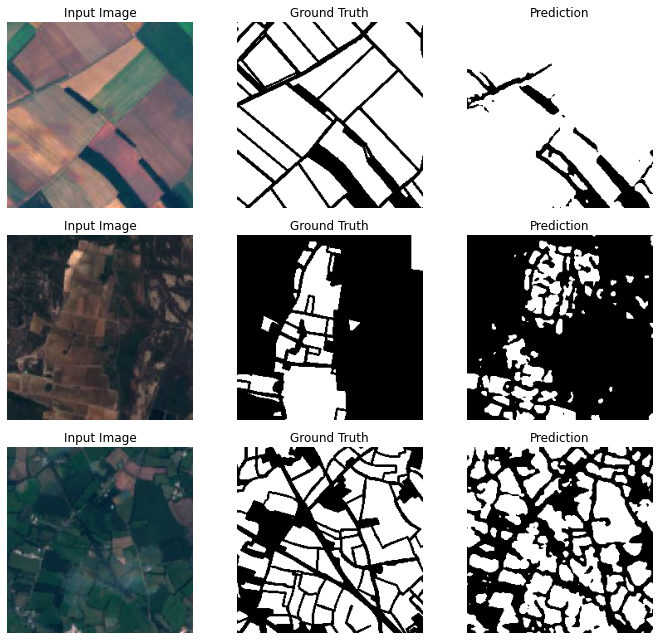

In [16]:
# Plotting Frozen
device="cuda"
encoder.eval()
decoder.eval()

images, masks = next(iter(test_loader))
images, masks = images.to(device), masks.to(device)
with torch.no_grad():
    encoder.to(device)
    decoder.to(device)
    outputs = decoder(encoder(images))
    preds = torch.sigmoid(outputs)
plot_predictions(images, masks, preds, invTrans, num_examples=3)

7. Compute error on test set


In [7]:
def test(test_loader, encoder, decoder, criterion, acc_metric, device): 
    encoder.to(device)
    decoder.to(device)
    encoder.eval()
    decoder.eval()
    criterion = criterion.to(device)
    acc_metric  = acc_metric.to(device)

    for batch_idx, (inp, target) in enumerate(test_loader):

        running_loss, running_acc = 0, 0
        # Move to the GPU
        if batch_idx % 10 == 0:
            print(f"Testing batch {batch_idx}")
        inp = inp.to(device)
        target = target.to(device)
        output = encoder(inp)
        output = decoder(output)
        loss = criterion(output, target)

        pred_prob = torch.sigmoid(output) #sigmoid activation function
        pred_label = pred_prob
        pred_label[pred_label>0.5]  =  1
        pred_label[pred_label<0.5]  =  0
        pred_label = pred_label.long()
        
        acc = acc_metric(pred_label,target)

        running_loss += loss.item() / inp.size(0)
        running_acc += acc.item() / inp.size(0)

        if batch_idx % 10 == 0:
            print(f"\t Test Loss: {loss.item():.4f}, Test Accuracy: {acc.item():.4f}")


In [11]:
device="cuda:0"

criterion = metrics.load(metric_name = "softiouloss", device=device)
acc_metric = metrics.load(metric_name = "iou", device=device)

test(test_loader, encoder, decoder, criterion, acc_metric, device=device)

Testing batch 0


/home/sl636/miniconda3/envs/swav-1/lib/python3.6/site-packages/torch/nn/functional.py:2506: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


	 Test Loss: 0.2122, Test Accuracy: 0.6215


RuntimeError: CUDA out of memory. Tried to allocate 196.00 MiB (GPU 0; 23.64 GiB total capacity; 21.89 GiB already allocated; 36.50 MiB free; 22.85 GiB reserved in total by PyTorch)